# Method 1: Convolutional Neural Network

For the first method, we decided to use a CNN which benefits from images as input. We can apply filters and kernel functions to reduce the dimensionality of our images.

## 1. Getting Started

First, we import the libraries we are going to use to train our Convolutional Neural Network. We will also define the environments relative paths and some utility/auxiliary functions.

### 1.1 Imports

In [1]:
import os
import sys
import csv
import random

import cv2
import numpy as np
import torch.nn as nn

### 1.2 Environment Configuration

In [2]:
# Setting the path of the training dataset (that was already provided to you)

running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
DATASET_PATH = "../data/sign_lang_train"

# Set the location of the dataset
if running_local:
    # If running on your local machine, the sign_lang_train folder's path should be specified here
    local_path = "../data/sign_lang_train"
    if os.path.exists(local_path):
        DATASET_PATH = local_path
else:
    # If running on the Jupyter hub, this data folder is already available
    # You DO NOT need to upload the data!
    DATASET_PATH = "/data/mlproject22/sign_lang_train"

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

### 1.3 Auxiliary Functions

In [3]:
# Auxiliary function
def read_csv(csv_file):
    with open(csv_file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

### 1.4 Load the Dataset (Sign-Languages)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

from string import ascii_lowercase

class SignLangDataset(Dataset):
    """Sign language dataset"""

    def __init__(self, csv_file, root_dir, class_index_map=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.class_index_map = class_index_map
        self.transform = transform
        # List of class names in order
        self.class_names = list(map(str, list(range(10)))) + list(ascii_lowercase)

    def __len__(self):
        """
        Calculates the length of the dataset-
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns one sample (dict consisting of an image and its label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read the image and labels
        image_path = os.path.join(self.root_dir, self.data[idx][1])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # The Shape of the image should be H, W, C where C=1
        image = np.expand_dims(image, 0)
        # The label is the index of the class name in the list ['0','1',...,'9','a','b',...'z']
        # because we should have integer labels in the range 0-35 (for 36 classes)
        label = self.class_names.index(self.data[idx][0])

        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [5]:
class CombinedDataset(Dataset):
    def __init__(self, original_dataset, augmentation):
        self.original_dataset = original_dataset
        self.augmented_data = augmentation

    def __len__(self):
        return len(self.original_dataset) + len(self.augmented_data)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            aug_idx = idx - len(self.original_dataset)
            return self.augmented_data[aug_idx]

### 1.5 Import the Network

In [6]:
from src.conv_nn import ConvNN

#ConvNN?
#ConvNN??
#help(ConvNN)

cnn = ConvNN().float()
cnn.train()

filename = "../models/cnn_weights.pt"

if not os.path.exists(filename):
    cnn.init_weights()
    torch.save(cnn.state_dict(), filename)
    print(f"Initialized weights saved to '{filename}'")
else:
    print(f"File '{filename}' already exists, skipping save.")

cnn.load_state_dict(torch.load("../models/cnn_weights.pt"))

print("ConvNN imported successfully!")

Initialized weights saved to '../models/cnn_weights.pt'
ConvNN imported successfully!


### 1.6 Split the Data

To authentically test if our model performs well on new data (data that was never seen during training), we will need a test set. But also we need to make sure not to overfit our data during the training which we achieve by using a validation set during the training. Using a validation set will also help to perform early stopping and can also be used as an estimate for the generalization error.

In [7]:
from torch.utils.data import random_split, DataLoader

dataset = SignLangDataset(csv_file='labels.csv', root_dir=DATASET_PATH)

### 1.7 Visualize the Data

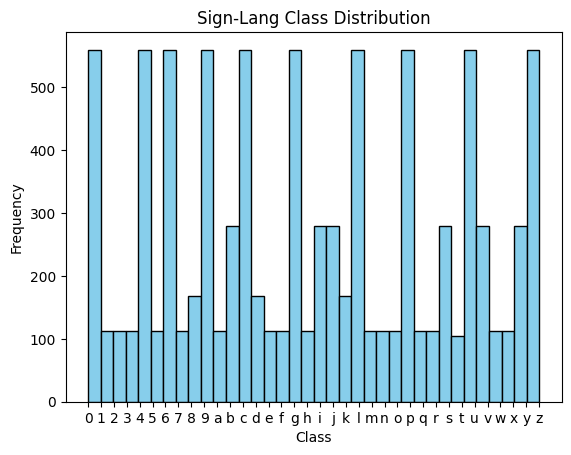

In [8]:
import matplotlib.pyplot as plt
from collections import defaultdict

labels = [data['label'] for data in dataset]

# Create histogram
plt.hist(labels, bins=36, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Sign-Lang Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(len(dataset.class_names)), dataset.class_names)

# Show plot
plt.show()

In [9]:
clustered_data = defaultdict(list)

max_bucket_size = 0

for data in dataset:
    clustered_data[data['label']].append(data)

for bucket in clustered_data.values():
    len_bucket = len(bucket)
    if len_bucket > max_bucket_size:
        max_bucket_size = len_bucket

for label, bucket in clustered_data.items():
    if len(bucket) < max_bucket_size - max_bucket_size * 0.1:
        print(f"To few Images of label: {label}; counted: {len(bucket)}")

To few Images of label: 7; counted: 112
To few Images of label: 18; counted: 280
To few Images of label: 31; counted: 280
To few Images of label: 17; counted: 112
To few Images of label: 13; counted: 168
To few Images of label: 2; counted: 112
To few Images of label: 29; counted: 104
To few Images of label: 33; counted: 112
To few Images of label: 23; counted: 112
To few Images of label: 14; counted: 112
To few Images of label: 26; counted: 112
To few Images of label: 5; counted: 112
To few Images of label: 24; counted: 112
To few Images of label: 28; counted: 280
To few Images of label: 8; counted: 168
To few Images of label: 20; counted: 168
To few Images of label: 22; counted: 112
To few Images of label: 19; counted: 280
To few Images of label: 11; counted: 280
To few Images of label: 34; counted: 280
To few Images of label: 27; counted: 112
To few Images of label: 15; counted: 112
To few Images of label: 32; counted: 112
To few Images of label: 10; counted: 112
To few Images of lab

In [10]:
from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image

torch.manual_seed(17)

augmented_data = []

augment = transforms.Compose([
    v2.RandomPerspective(distortion_scale=0.15),
    v2.RandomRotation(degrees=27),
    #v2.RandomApply([v2.ElasticTransform()]),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))]),
    transforms.ToTensor()
])

max_show = 8

for label, bucket in clustered_data.items():
    len_bucket = len(bucket)

    if len_bucket < max_bucket_size - max_bucket_size * 0.1:
        needed = max_bucket_size - len_bucket

        for i in range(needed):
            img_np = random.choice(bucket)['image']  # (1, H, W), uint8
            img_2d = np.squeeze(img_np, axis=0)  # (H, W)
            img_pil = Image.fromarray(img_2d.astype(np.uint8), mode='L')

            augmented_img = augment(img_pil)  # (1, H, W), float32
            augmented_np = augmented_img.numpy()  # back to NumPy

            augmented_data.append({'image': augmented_np, 'label': label})

print(f"Augmented {len(augmented_data)} images.")

Augmented 10480 images.


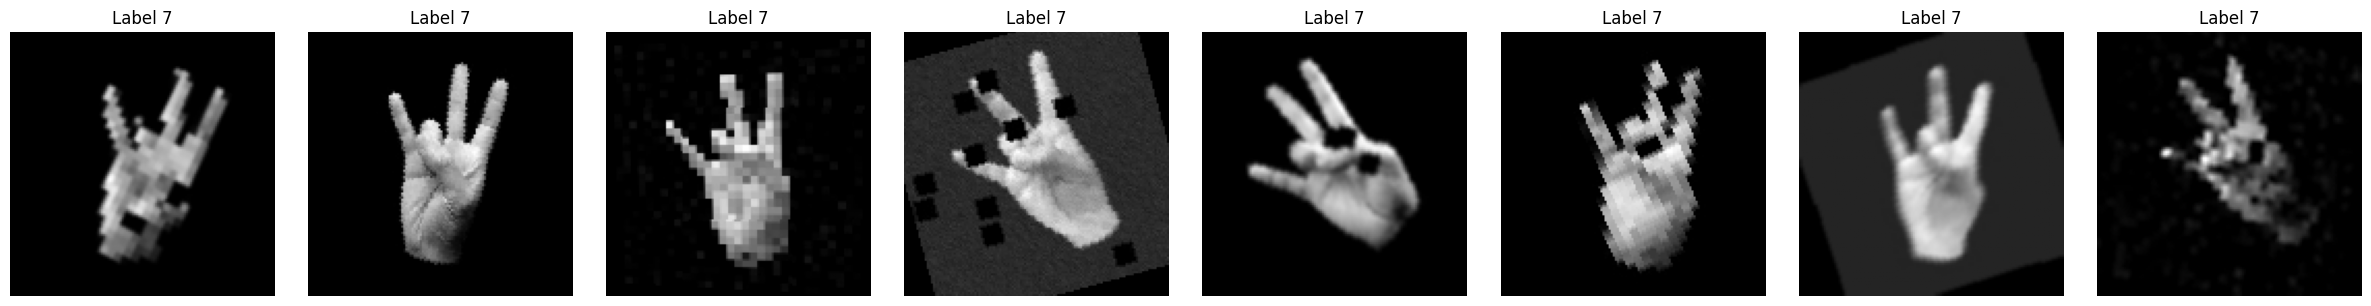

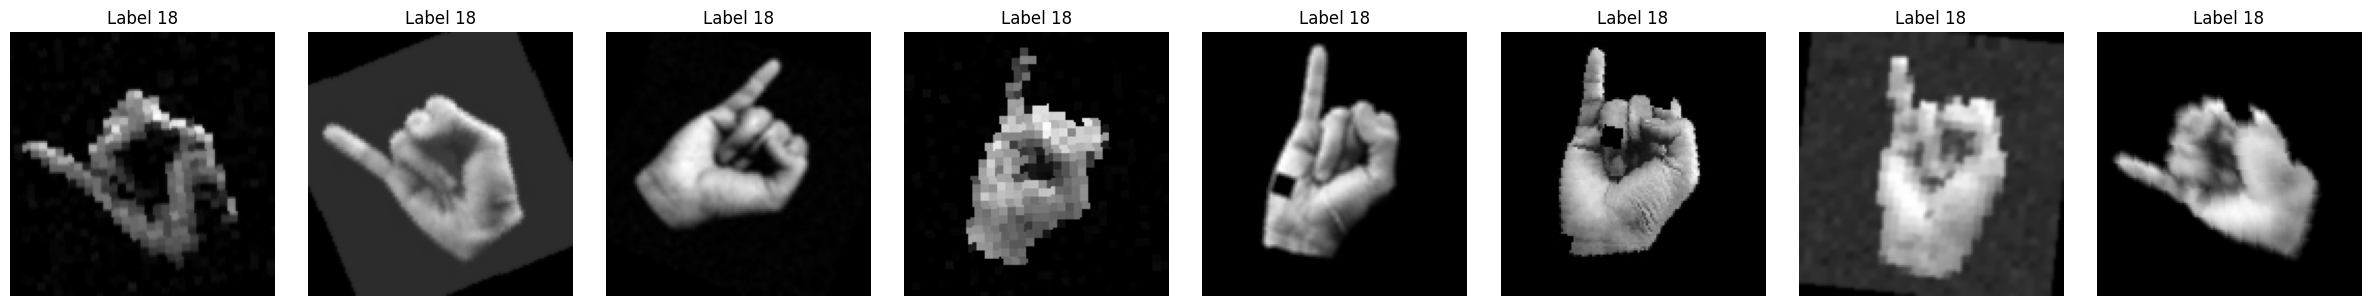

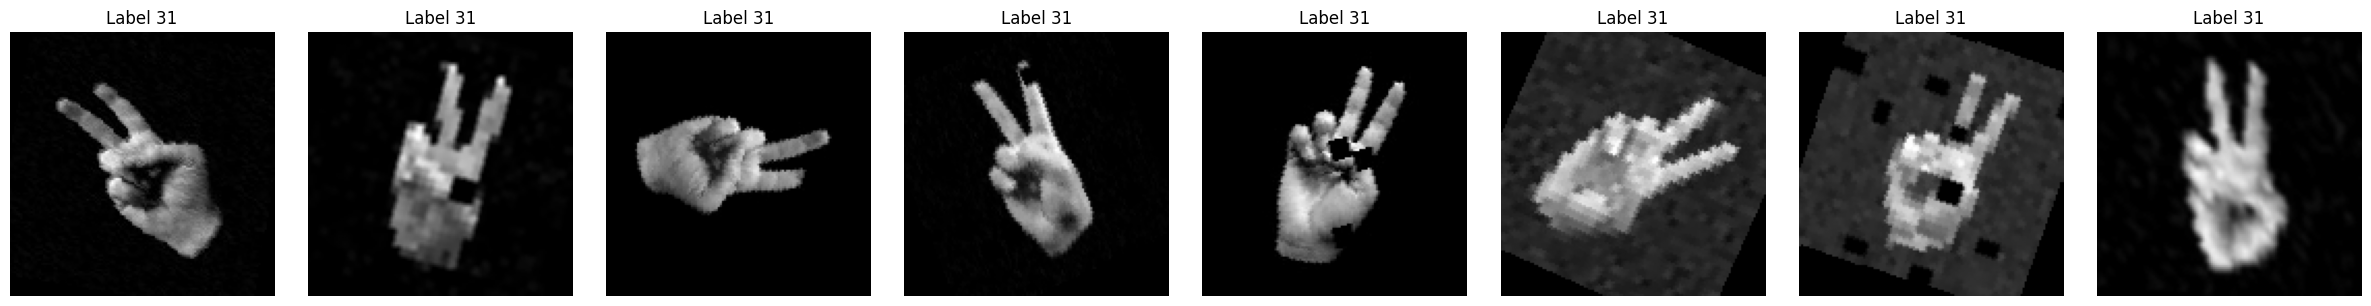

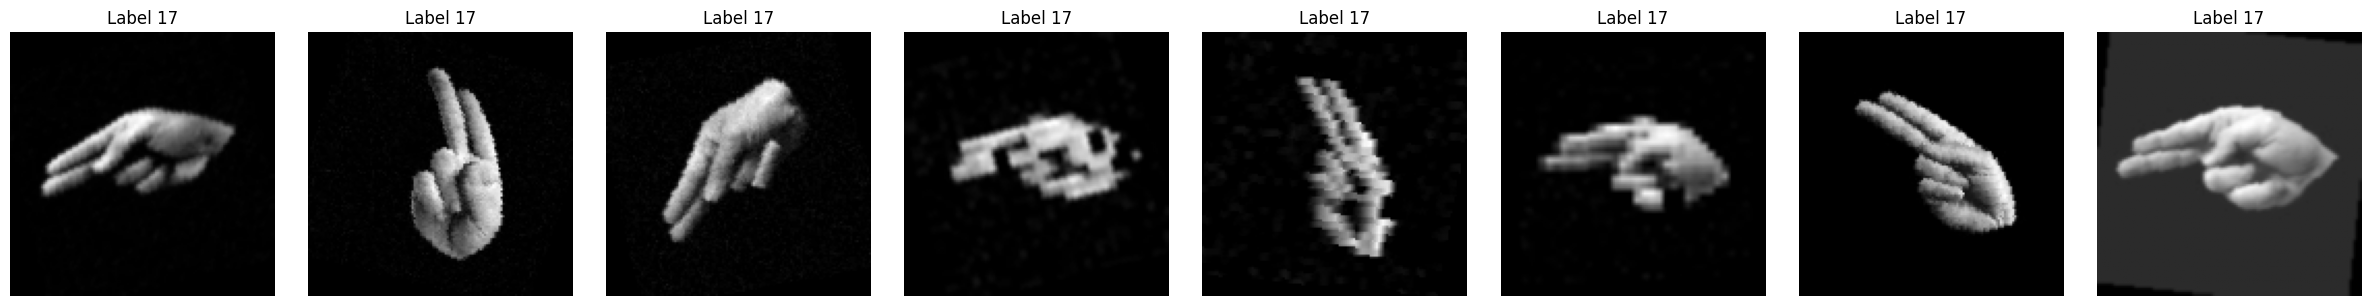

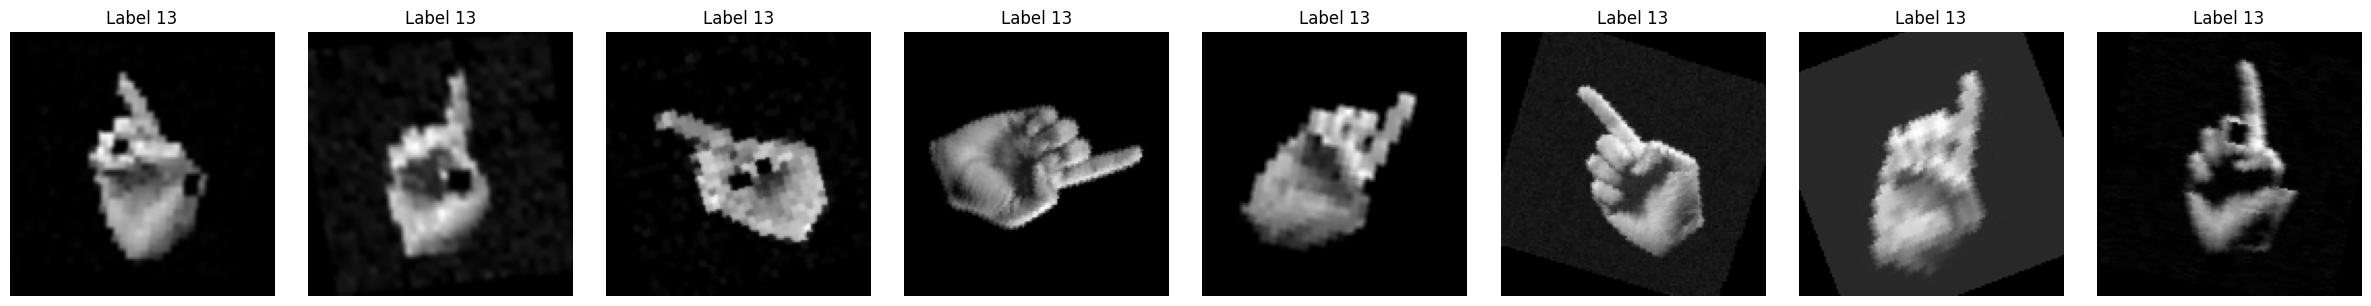

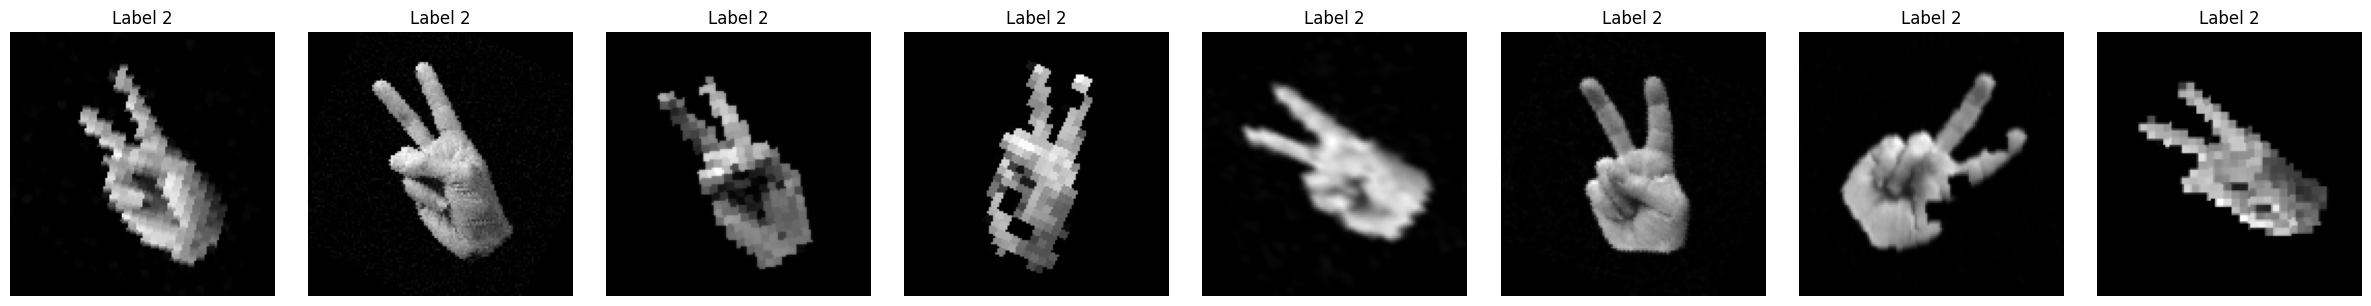

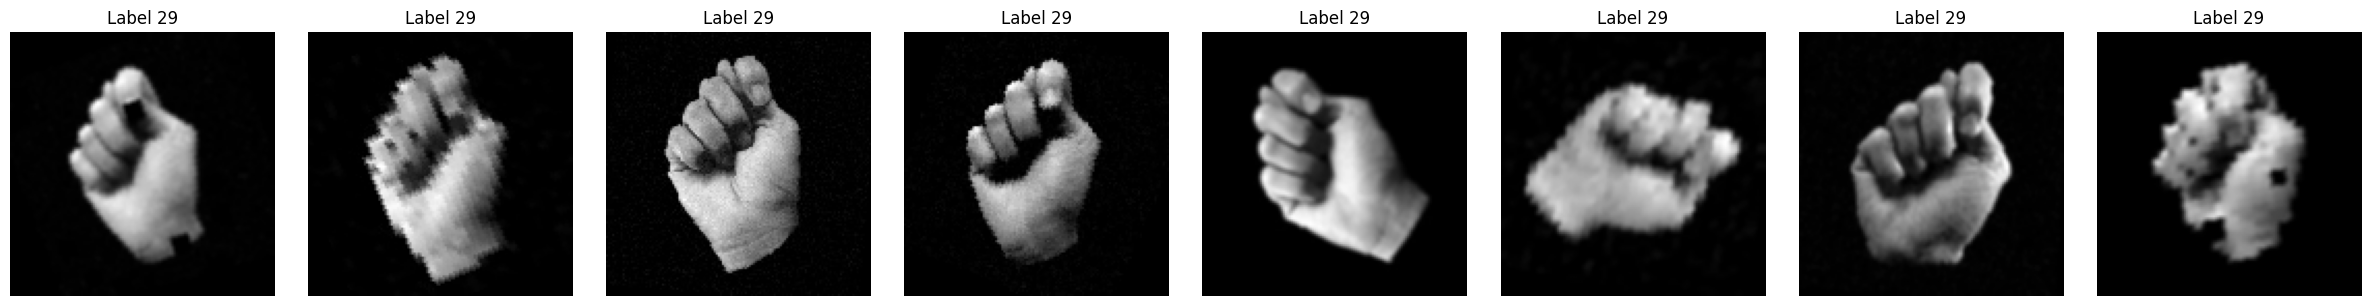

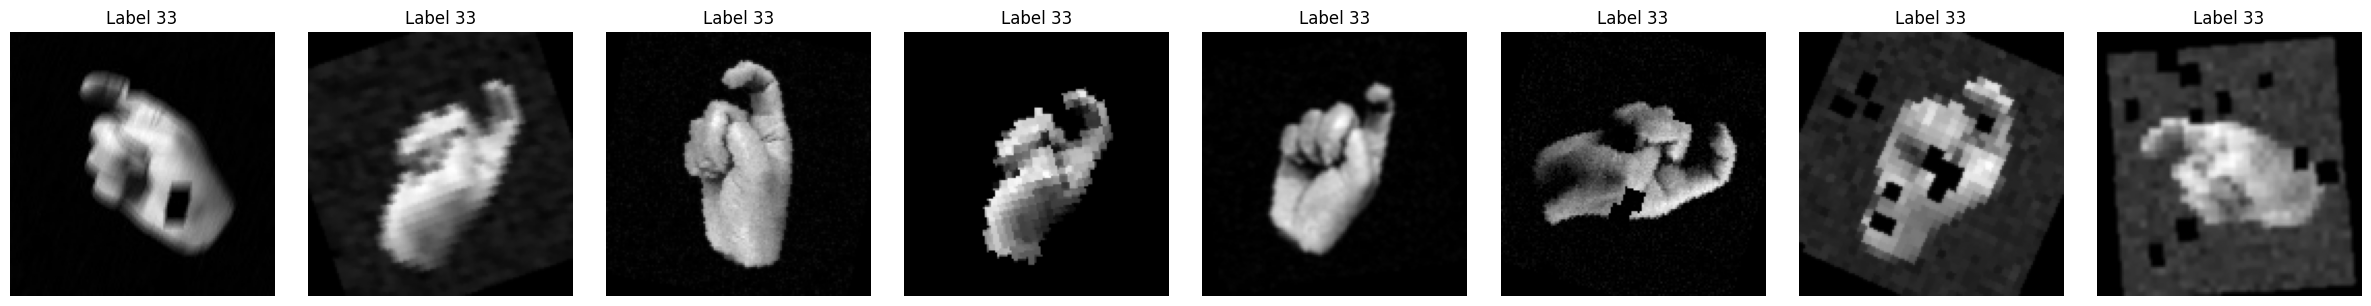

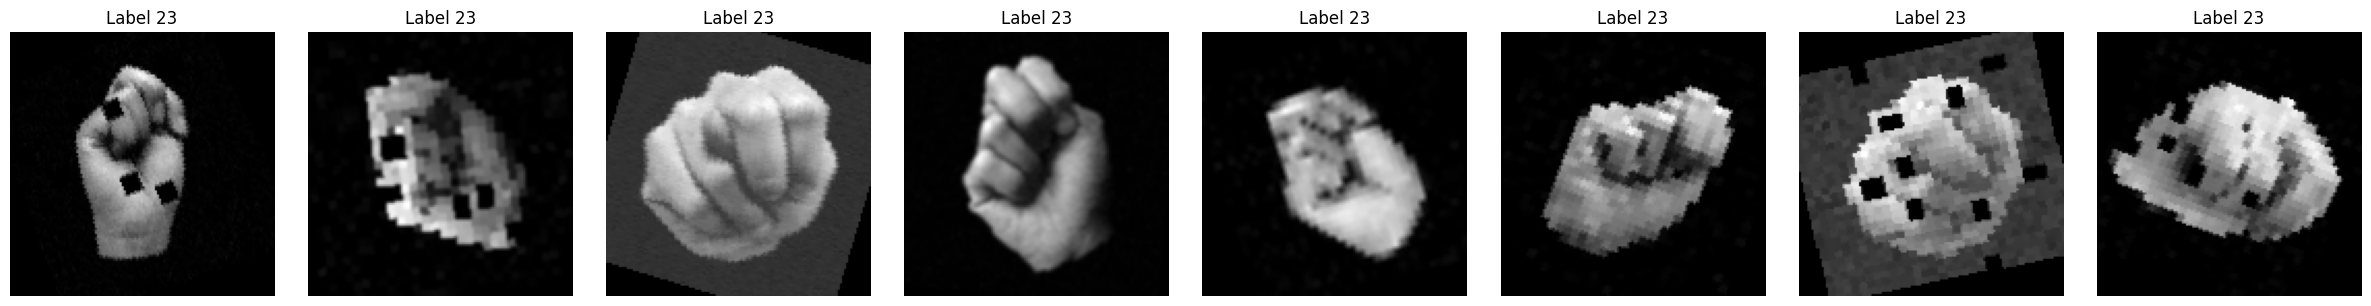

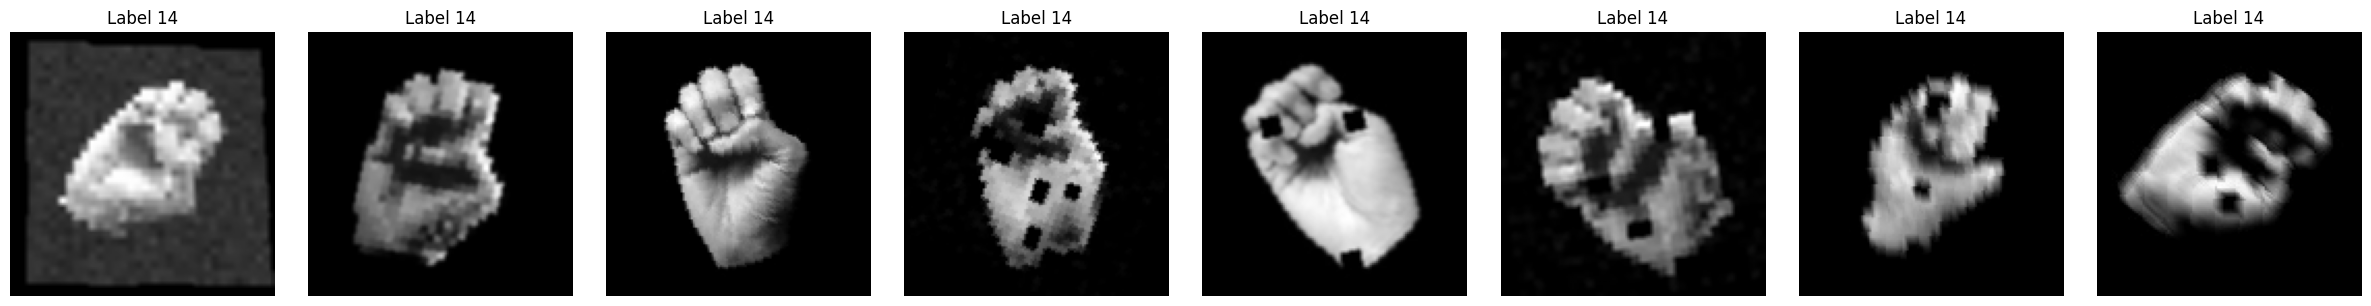

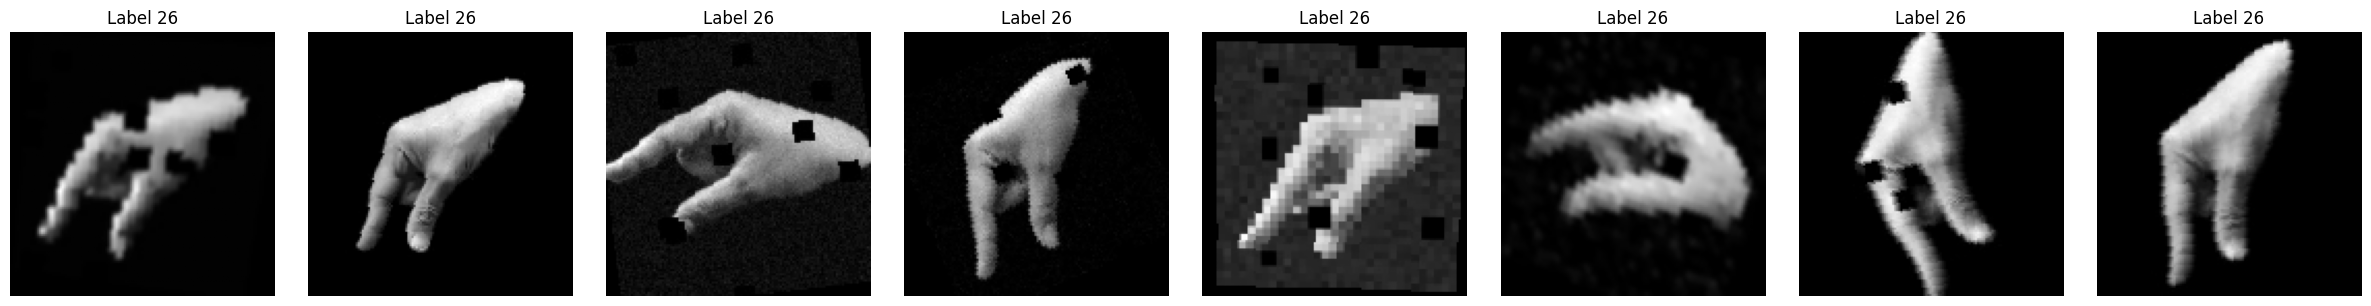

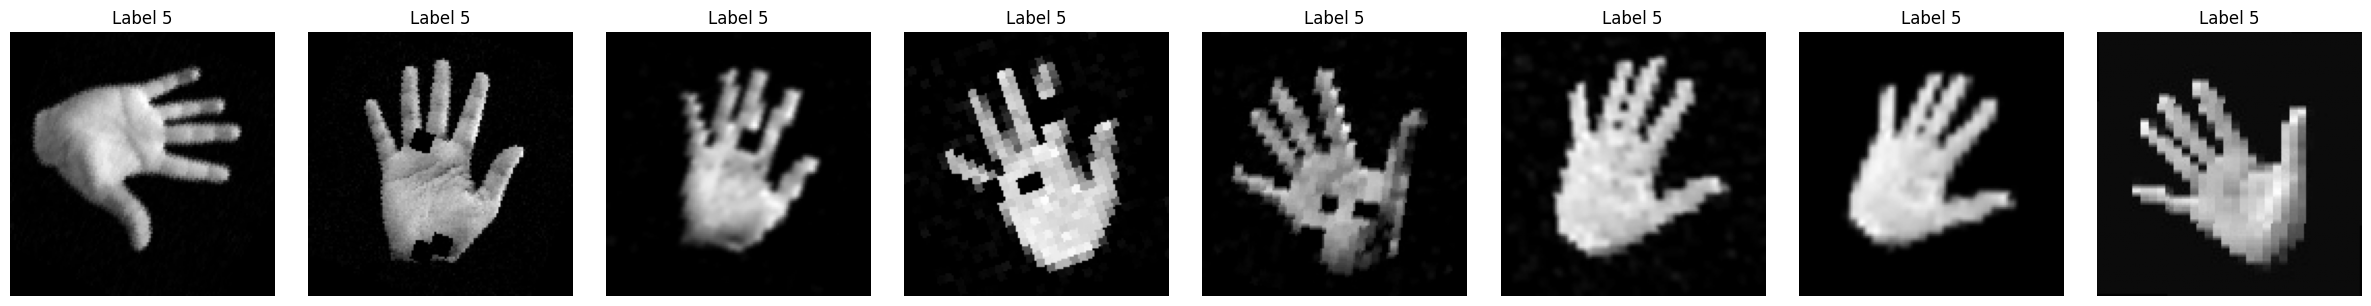

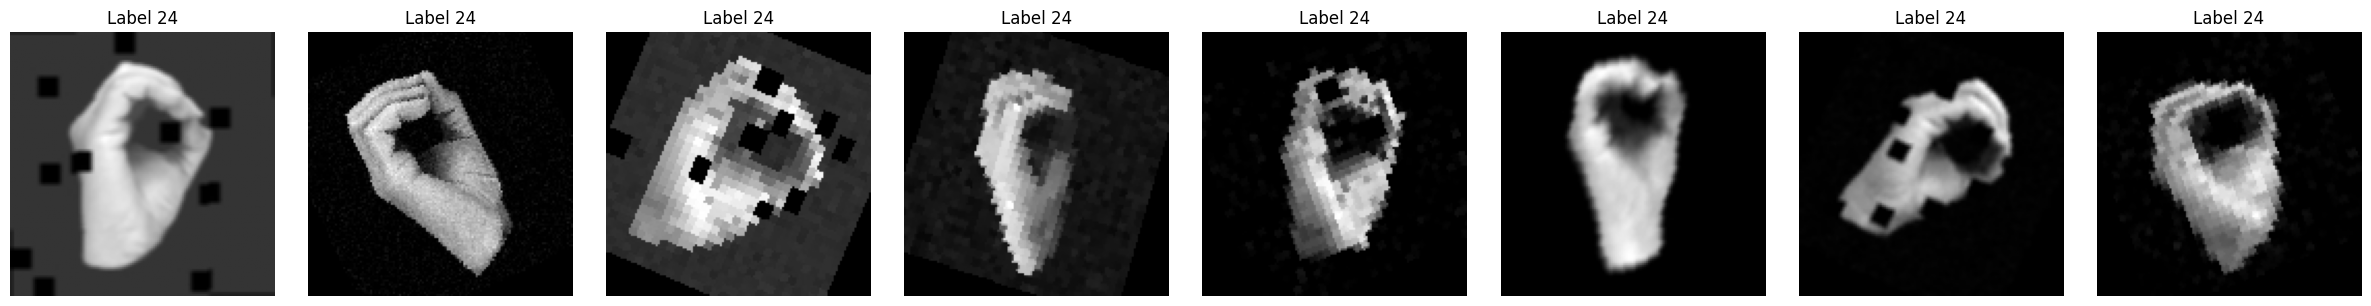

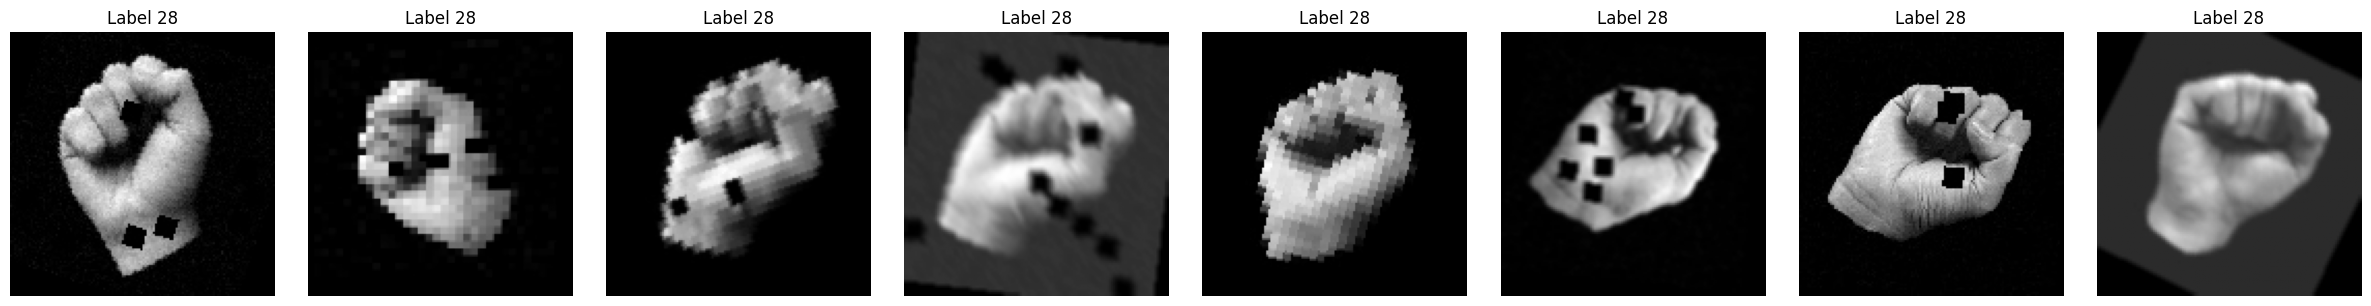

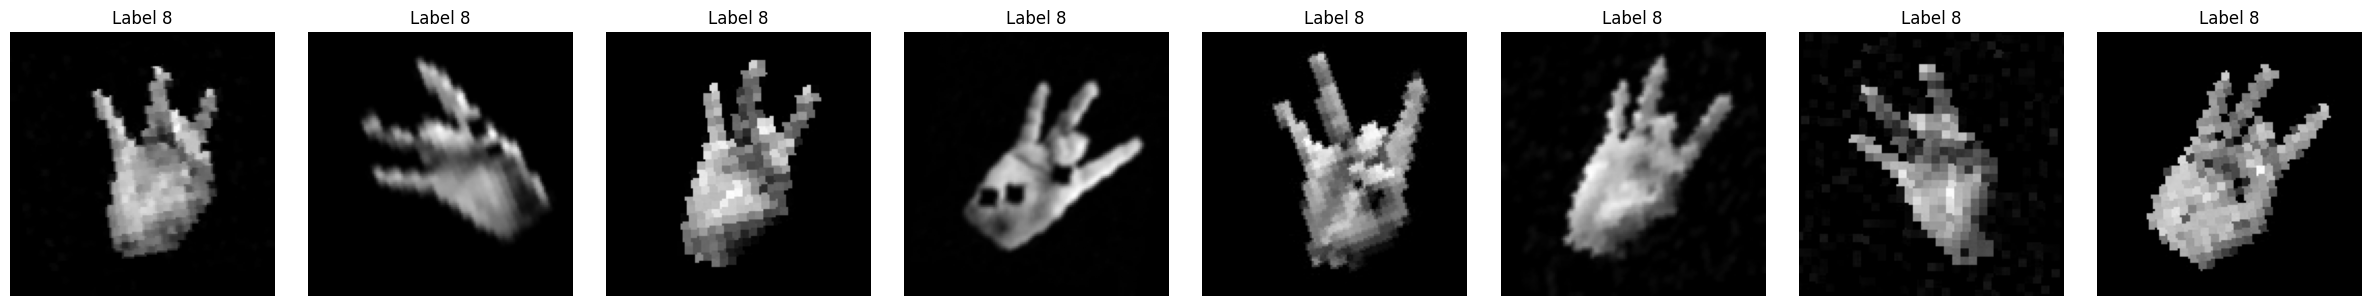

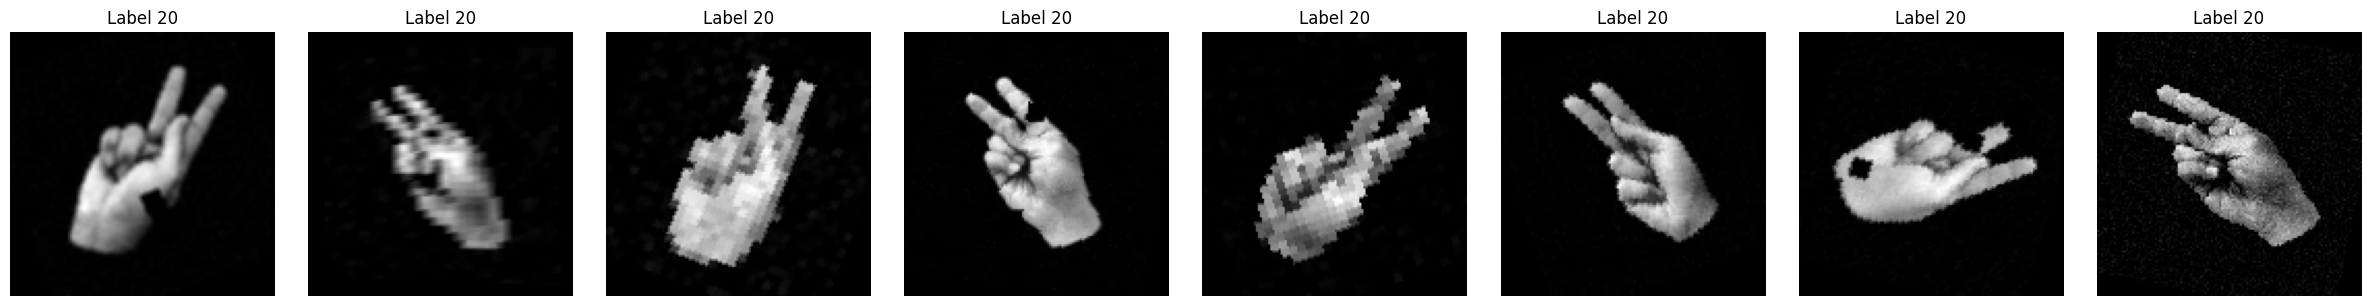

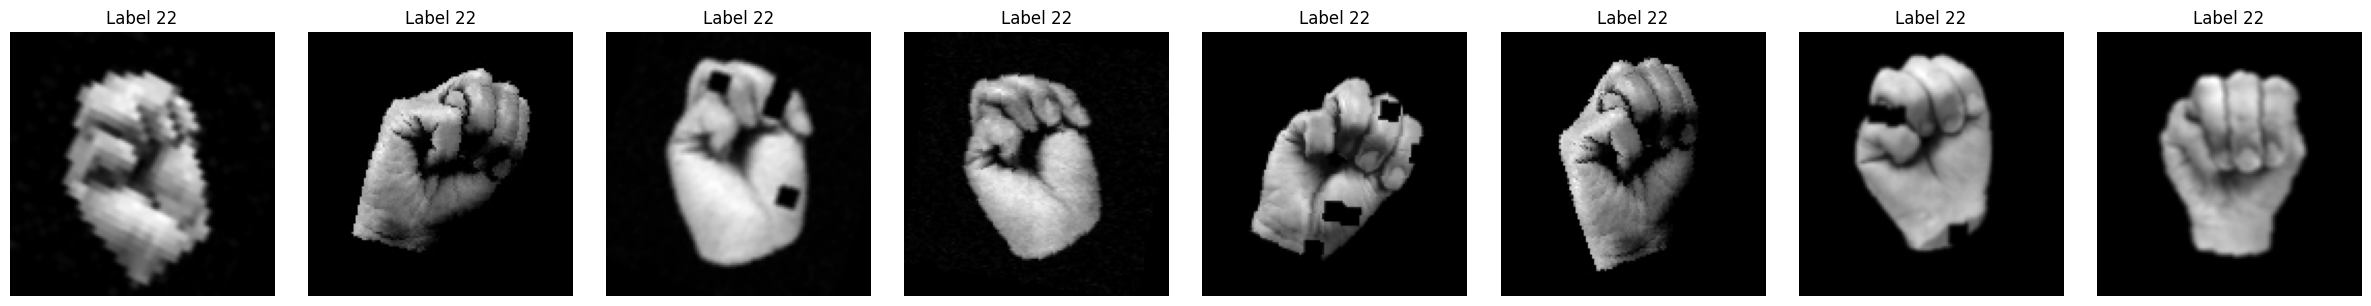

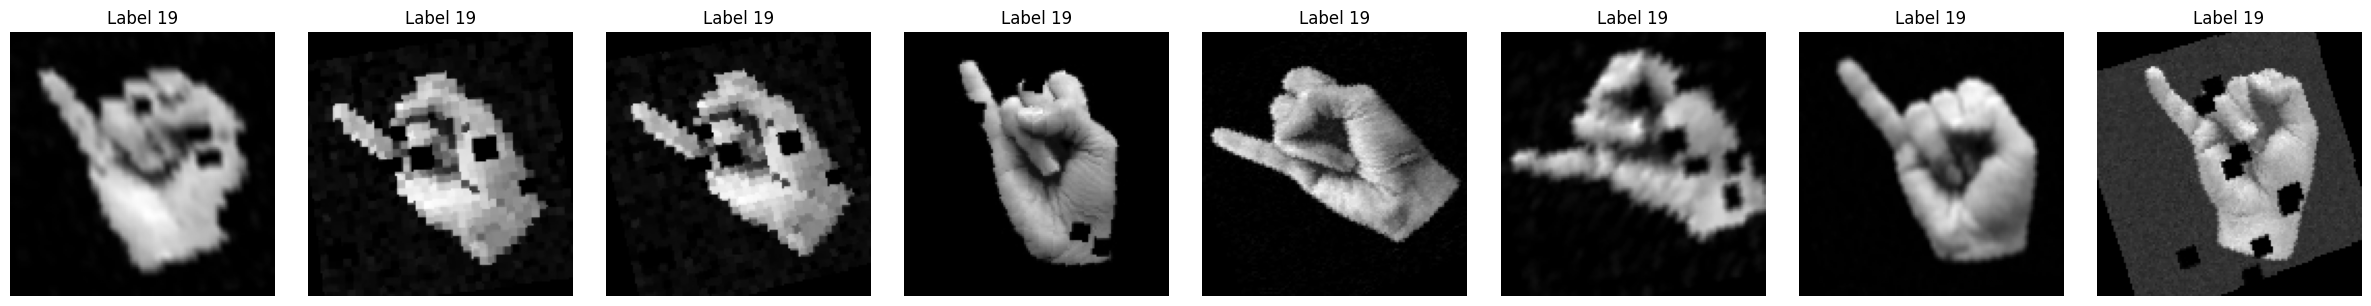

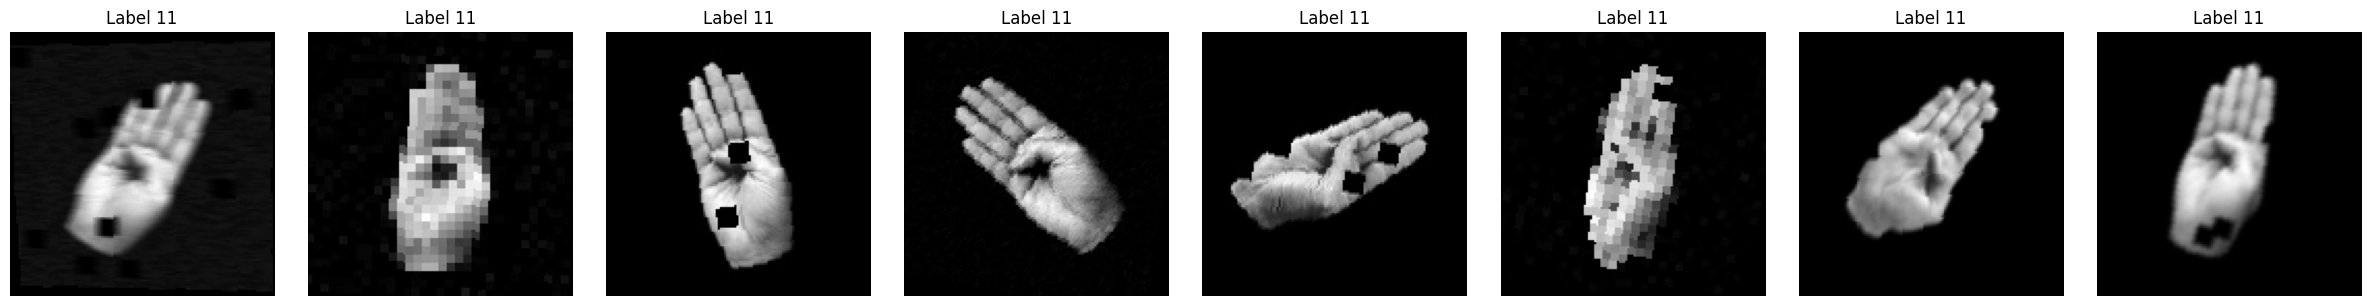

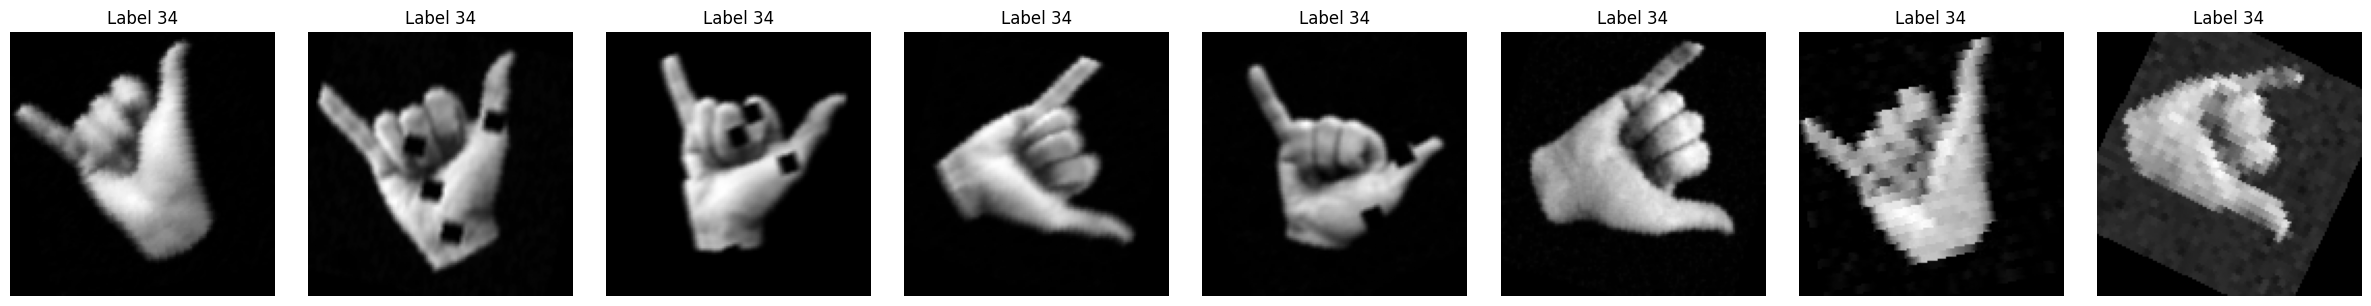

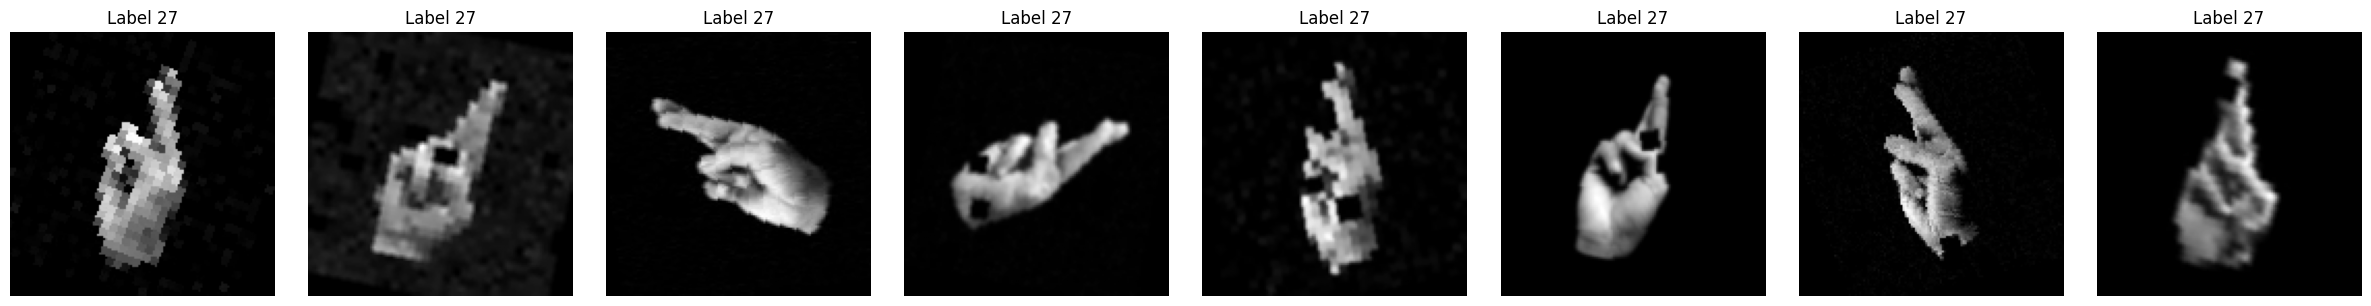

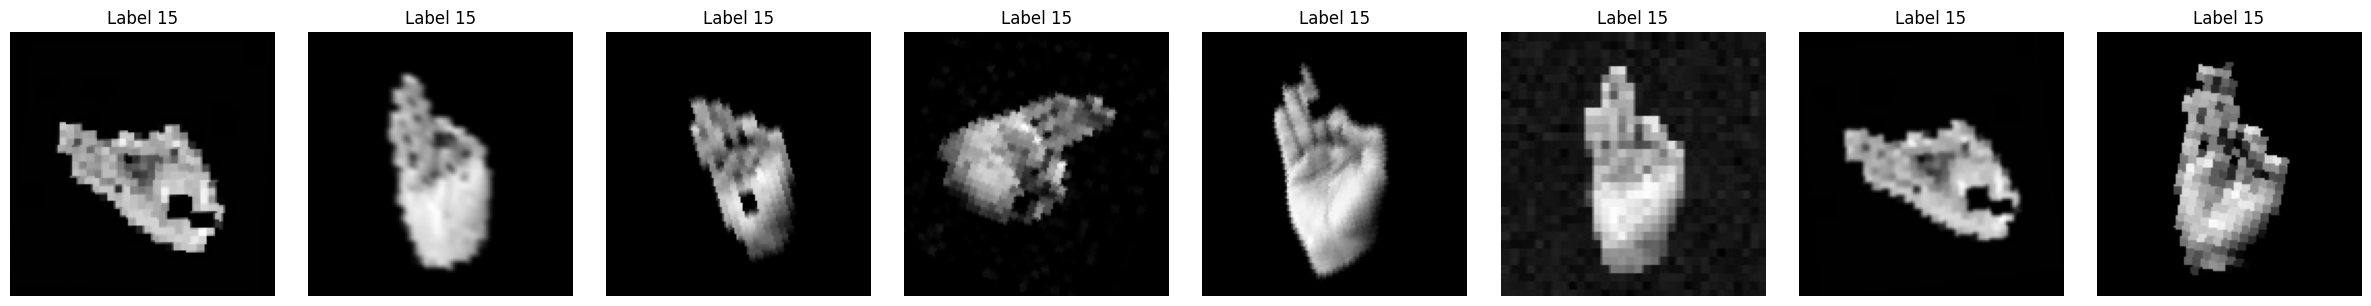

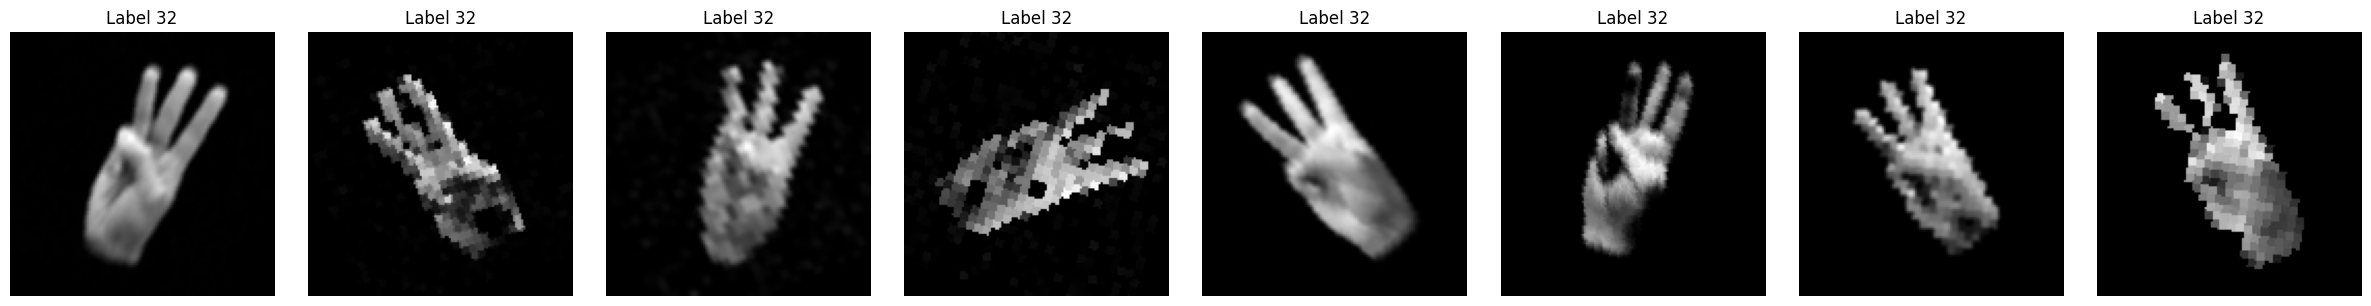

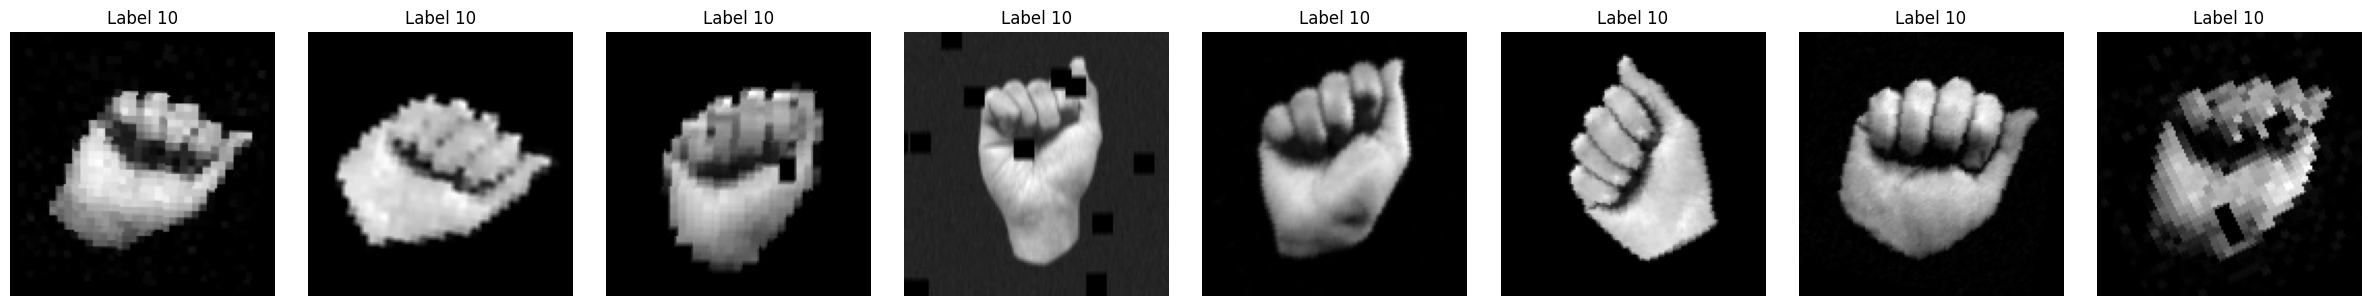

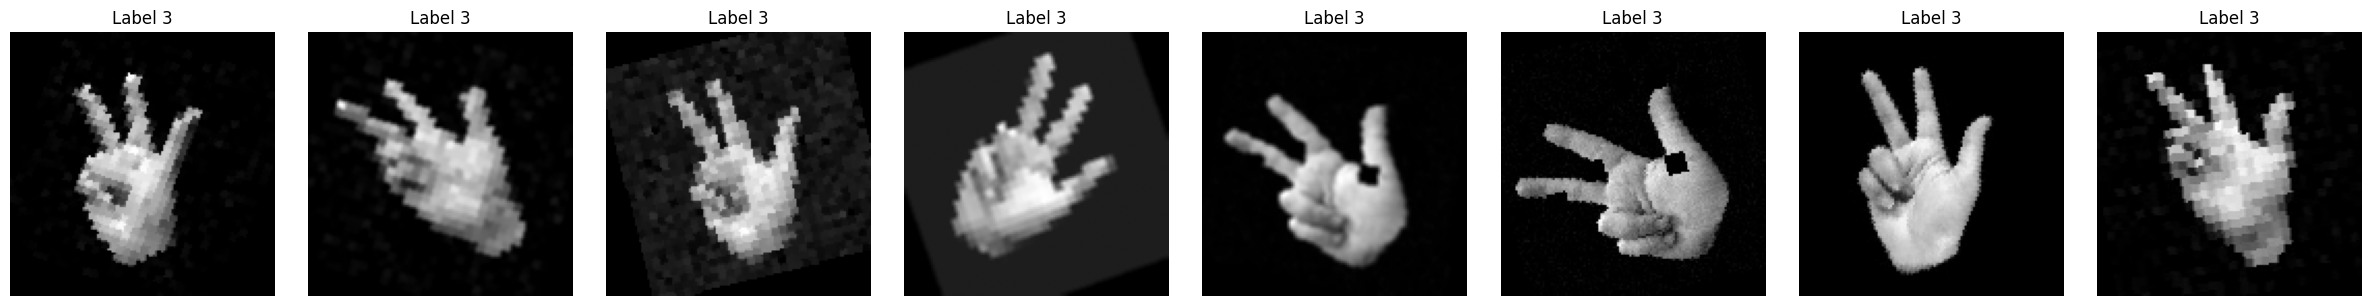

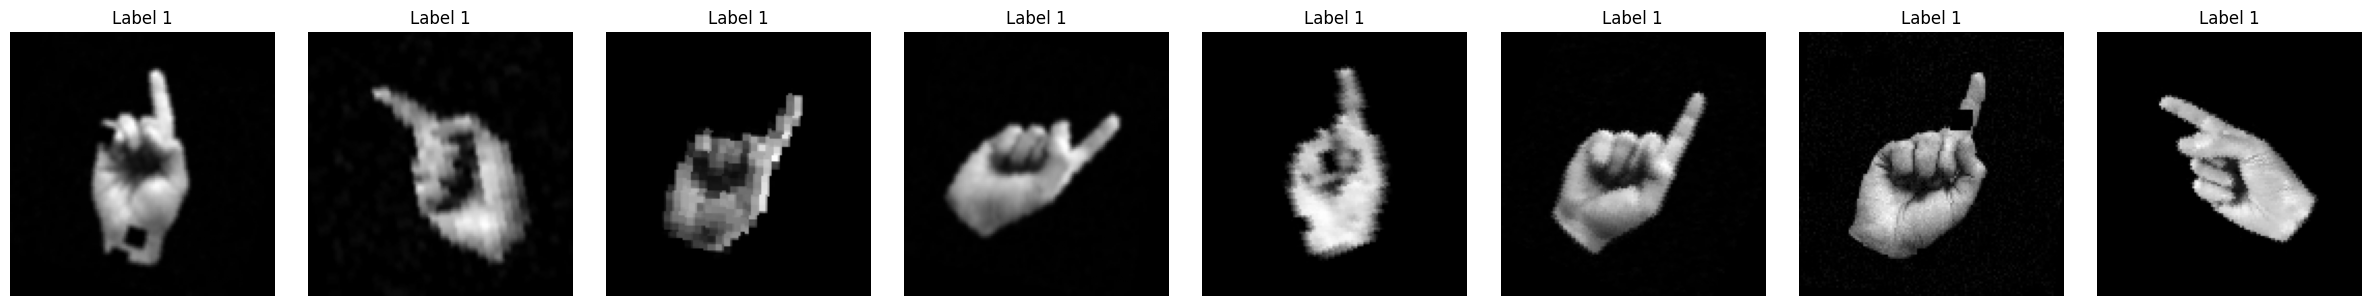

In [11]:
grouped_augmented = defaultdict(list)
for entry in augmented_data:
    grouped_augmented[entry['label']].append(entry['image'])

for label, images in grouped_augmented.items():
    num_imgs = min(len(images), 8)
    fig, axes = plt.subplots(1, num_imgs, figsize=(num_imgs * 3, 3))

    if num_imgs == 1:
        axes = [axes]

    for j in range(num_imgs):
        img = images[j][0]
        axes[j].imshow(img, cmap='gray')
        axes[j].axis('off')
        axes[j].set_title(f"Label {label}")

    plt.tight_layout()
    plt.show()

In [12]:
augmented_dataset = CombinedDataset(dataset, augmented_data)

In [13]:
N = len(augmented_dataset)

train_size = int(0.8*N)
test_size = int(0.1*N)
validation_size = int(0.1*N)

training_dataset, test_dataset, validation_dataset = random_split(augmented_dataset, [train_size, test_size, validation_size])

### 2. Train the model

### 2.1 Use dataloader to create batches for split dataset

First, we will load our dataset by using a dataloader and test if everything works well by printing a random batch.

In [14]:
train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [15]:
column_width = 70
total_width = 100

### 2.2 Hyperparameters

In [16]:
EPOCHS = 100
PATIENCE = 5

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.002)

In [18]:
def print_progress_bar(iteration, total, epo, length=40):
    current = iteration + epo * total
    total_all = total * EPOCHS

    percent = 100 * (current / total_all)
    filled_length = int(length * current // total_all)

    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'Progress: |{bar}| {percent:.1f}% Complete\r')
    sys.stdout.flush()

    if current == total_all:
        sys.stdout.write('\n')


def print_train_details(epoch, iteration, loss, batch_acc, epoch_acc, total_batches):
    l_text = f"Epoch {epoch},\tBatch {iteration},\tloss: {loss.item():.4f}"
    r_text = f"Batch Accuracy: {batch_acc:.4f}%,\tEpoch Accuracy: {epoch_acc:.4f}%"
    aligned_text = (l_text.ljust(int(column_width)) + r_text.rjust(int(column_width)))
    print(aligned_text.center(total_width))
    print('[' + ''.center(column_width*2, '-') + ']')
    print_progress_bar(iteration + 1, total_batches, epo=epoch, length=40)

def print_validation_details(val_acc, best_acc, loss):
    l_text = f"loss: {loss.item():.4f},\tPatience-Level: {patience_counter}"
    r_text = f"Best Accuracy so far: {best_acc:.4f}%,\t Validation Accuracy: {val_acc:.4f}%"
    aligned_text = (l_text.ljust(int(column_width)) + r_text.rjust(int(column_width)))
    print(aligned_text.center(total_width))

In [19]:
best_val = float('-inf')
patience_counter = 0
for epoch in range(EPOCHS):
    text = "=====Training - Tracker====="
    print(text.center(column_width*2))
    cnn.train()

    epoch_total = 0
    trn_corr = 0
    batch_size = 0
    total_batches = len(train_loader)


    for i, batch in enumerate(train_loader):
        images = batch['image'].float()
        labels = batch['label']
        batch_size = images.size(0)

        y_pred = cnn(images)
        loss = criterion(y_pred, labels)

        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr
        epoch_total += batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            batch_acc = batch_corr / batch_size * 100
            epoch_acc = trn_corr / epoch_total * 100
            print_train_details(epoch, i, loss, batch_acc, epoch_acc, total_batches)

    text = "=====Validation - Analysis====="
    print(text.center(column_width*2))

    val_corr = 0
    loss = 0
    iter = 0
    improvement = False
    total_batches = len(validation_loader)
    num_samples = 0
    for i, batch in enumerate(validation_loader):
        images = batch['image'].float()
        labels = batch['label']
        batch_size = images.size(0)

        cnn.eval()
        y_pred = cnn(images)
        loss = criterion(y_pred, labels)

        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == labels).sum()
        val_corr += batch_corr
        num_samples += batch_size
    loss = loss / total_batches
    val_acc = val_corr / num_samples * 100

    if val_acc > best_val:
        patience_counter = 0
        improvement = True
        best_val = val_acc
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Patience exceeded! Breaking training...")
            print_validation_details(val_acc, best_val, loss)
            break

    print_validation_details(val_acc, best_val, loss)

                                                        =====Training - Tracker=====                                                        
Epoch 0,	Batch 0,	loss: 10.2628                                                             Batch Accuracy: 1.5625%,	Epoch Accuracy: 1.5625%
[--------------------------------------------------------------------------------------------------------------------------------------------]
Epoch 0,	Batch 50,	loss: 3.0960                                                            Batch Accuracy: 20.3125%,	Epoch Accuracy: 7.2610%
[--------------------------------------------------------------------------------------------------------------------------------------------]
Epoch 0,	Batch 100,	loss: 3.2157                                                          Batch Accuracy: 25.0000%,	Epoch Accuracy: 13.3045%
[--------------------------------------------------------------------------------------------------------------------------------------------]
Epoch 0